# Urban Heat Island (UHI) Benchmark Notebook
## University of Maryland - Information Challenge 2025 (IC25)

## Challenge Overview

<p align="justify">Welcome to the 2025 University of Maryland - Information Challenge 2025! The objective of this challenge is to build a machine learning model to predict urban heat island (UHI) hotspots in a specified region. By the end of the challenge, you will have developed a regression model capable of predicting the intensity of the UHI effect. Participants will be given ground-level air temperature data in an index format which was collected on 7-Aug-2022 in Montgomery County, Maryland. This dataset constitutes traverse points (latitude and longitude) and their corresponding UHI (Urban Heat Island) index values. Participants will use this dataset to build a regression model to predict UHI index values for a given set of locations. It is important to understand that the UHI Index at any given location is indicative of the relative temperature elevation at that specific point compared to the region's average temperature.
</p>

<b>Challenge Aim: </b><p align="justify"> <p>

<p align="justify">In this notebook, we will demonstrate a basic model workflow that can serve as a starting point for the challenge. The basic model has been constructed to predict the Urban Heat Island (UHI) index using features from the Sentinel-2 satellite dataset as predictor variables. In this demonstration, we utilized three features from the Sentinel-2 dataset: band B02 (Blue), band B03 (Green), and NDVI (Normalized Difference Vegetation Index) derived from bands B04 (Red) and B08 (Near Infrared). A random forest regression model was then trained using these features.
    
These features were extracted from a GeoTIFF image created by the Sentinel-2 sample notebook. For the sample model shown in this notebook, data from a single day (13th August 2022) was considered, assuming that the values of bands B02, B03, B04, and B08 for this specific date are representative of the UHI index behavior at any location. Participants should review the details of the Sentinel-2 sample notebook to gain an understanding of the data and options for modifying the output product. 
    
</p>

<p align="justify">Most of the functions presented in this notebook were adapted from the <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2-Level-2A notebook</a> found in the Planetary Computer portal.</p>

<p align="justify">Please note that this notebook is just a starting point. We have made many assumptions in this notebook that you may think are not best for solving the challenge effectively. You are encouraged to modify these functions, rewrite them, or try an entirely new approach.</p>


In [184]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows  
from rasterio import features  
from rasterio import warp
from rasterio.warp import transform_bounds 
from rasterio.windows import from_bounds 

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm

In [185]:
# Combining ground data and final data into a single dataset.
uhi = pd.read_csv("output150.csv")
train_data = pd.read_csv("Training_Data_IC25.csv")  # Second dataset

# Combine them side by side
uhi_data = pd.concat([train_data, uhi], axis=1)
uhi_data.columns =  ['Longitude', 'Latitude', 'UHI Index', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
uhi_data.head()

,Longitude,Latitude,UHI Index,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12
0,-77.302700,39.109905,0.993571,1289.9398,1393.8982,1635.7944,1441.7383,1982.4756,3750.9397,4401.0405,4686.7540,4682.5430,2977.9907,2021.1776
1,-77.302690,39.109855,0.994674,1290.3641,1394.5819,1634.0217,1444.1836,1980.1826,3731.2034,4377.9480,4665.0894,4661.1680,2981.7966,2025.0051
2,-77.302677,39.109960,0.993571,1289.7790,1392.4253,1636.0726,1437.6234,1981.5042,3767.5405,4420.5330,4702.7593,4698.5444,2969.1711,2013.7863
3,-77.302655,39.109808,0.994674,1291.1205,1395.9470,1633.9034,1446.8152,1980.6470,3720.9492,4366.9160,4651.7050,4652.1100,2988.6448,2030.4445
4,-77.302630,39.110017,0.993571,1289.9150,1391.5839,1636.1950,1433.2054,1980.7296,3776.2056,4432.6600,4707.6600,4706.2770,2959.6165,2007.1771


In [186]:
# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
# See the Sentinel-2 sample notebook for more information about the NDVI index
uhi_data['NDVI'] = (uhi_data['B08'] - uhi_data['B04']) / (uhi_data['B08'] +  uhi_data['B04'])
uhi_data['NDVI'] = uhi_data['NDVI'].replace([np.inf, -np.inf], np.nan) 

uhi_data['NDBI'] = (uhi_data['B11'] - uhi_data['B08']) / (uhi_data['B11'] + uhi_data['B08'])
uhi_data['NDBI'] = uhi_data['NDBI'].replace([np.inf, -np.inf], np.nan) 

uhi_data['NDWI'] = (uhi_data['B03'] - uhi_data['B08']) / (uhi_data['B03'] + uhi_data['B08'])
uhi_data['NDWI'] = uhi_data['NDWI'].replace([np.inf, -np.inf], np.nan) 

## Removing duplicates
Identical or duplicate entries are removed based on specific columns, in our case [ 'B01','B04','B06','B08','NDVI']. This ensures that the dataset is not biased or skewed by repetitive data, allowing the model to train on unique, relevant observations.

In [187]:
# Remove duplicate rows from the DataFrame based on specified columns and keep the first occurrence
columns_to_check = ['B01', 'B02','B03','B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12', 'NDVI', 'NDBI', 'NDWI']
for col in columns_to_check:
    # Check if the value is a numpy array and has more than one dimension
    uhi_data[col] = uhi_data[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# Now remove duplicates
uhi_data = uhi_data.drop_duplicates(subset=columns_to_check, keep='first')

uhi_data["B11/B12"] = uhi_data["B11"] / uhi_data["B12"] 
uhi_data["VWI"] = uhi_data["B08"] / uhi_data["B11"]  
uhi_data["Building_Index"] = uhi_data["B11"] / uhi_data["B12"] 
uhi_data["Soil_Ratio"] = uhi_data["B06"] / uhi_data["B07"] 
uhi_data["Vegetation_Health"] = uhi_data["B08"] / uhi_data["B02"]
uhi_data["NDVI_NDBI"] = uhi_data["NDVI"] * uhi_data["NDBI"]
uhi_data["NDVI_NDWI"] = uhi_data["NDVI"] * uhi_data["NDWI"]
uhi_data["NDBI_NDWI"] = uhi_data["NDBI"] * uhi_data["NDWI"]
uhi_data["B08_NDVI"] = uhi_data["B08"] * uhi_data["NDVI"]
uhi_data.head()


,Longitude,Latitude,UHI Index,B01,B02,B03,B04,B05,B06,B07,...,NDWI,B11/B12,VWI,Building_Index,Soil_Ratio,Vegetation_Health,NDVI_NDBI,NDVI_NDWI,NDBI_NDWI,B08_NDVI
0,-77.302700,39.109905,0.993571,1289.9398,1393.8982,1635.7944,1441.7383,1982.4756,3750.9397,4401.0405,...,-0.482552,1.473394,1.573797,1.473394,0.852285,3.362336,-0.118045,-0.255510,0.107579,2481.620204
1,-77.302690,39.109855,0.994674,1290.3641,1394.5819,1634.0217,1444.1836,1980.1826,3731.2034,4377.9480,...,-0.481190,1.472488,1.564523,1.472488,0.852272,3.345153,-0.116055,-0.253691,0.105923,2459.509258
2,-77.302677,39.109960,0.993571,1289.7790,1392.4253,1636.0726,1437.6234,1981.5042,3767.5405,4420.5330,...,-0.483794,1.474422,1.583863,1.474422,0.852282,3.377387,-0.120156,-0.257256,0.109320,2500.682607
3,-77.302655,39.109808,0.994674,1291.1205,1395.9470,1633.9034,1446.8152,1980.6470,3720.9492,4366.9160,...,-0.480113,1.471917,1.556460,1.471917,0.852077,3.332293,-0.114389,-0.252309,0.104505,2444.560552
4,-77.302630,39.110017,0.993571,1289.9150,1391.5839,1636.1950,1433.2054,1980.7296,3776.2056,4432.6600,...,-0.484164,1.474517,1.590632,1.474517,0.851905,3.382951,-0.121568,-0.258168,0.110383,2510.235600


In [188]:
# Resetting the index of the dataset
uhi_data=uhi_data.reset_index(drop=True)

## Correlation Coeficient between UHI Index	and other features

NDVI_NDBI            0.441727
NDVI_NDWI            0.430368
NDBI                 0.419182
B12                  0.411098
Soil_Ratio           0.409217
NDWI                 0.408341
B04                  0.390031
B01                  0.388055
B03                  0.386304
B02                  0.384075
B05                  0.378022
B11                  0.231763
B06                 -0.161686
B07                 -0.280604
B08                 -0.303825
B8A                 -0.305213
B08_NDVI            -0.401195
NDVI                -0.406883
Vegetation_Health   -0.424578
Building_Index      -0.428648
B11/B12             -0.428648
VWI                 -0.431685
NDBI_NDWI           -0.442677
dtype: float64


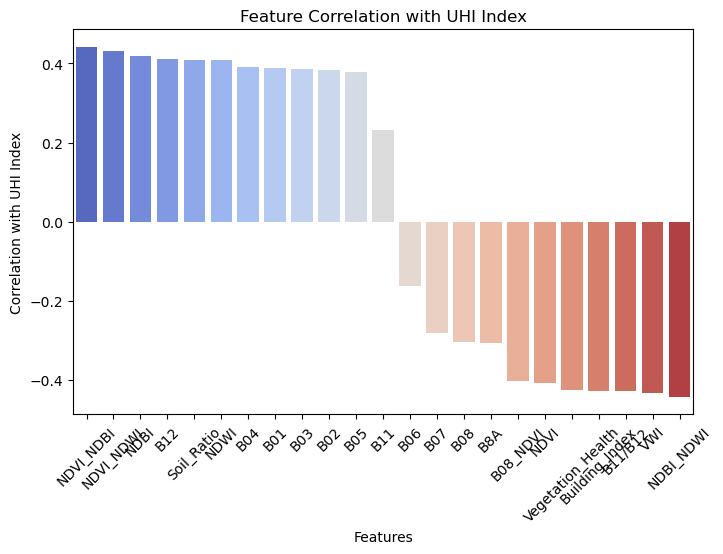

Selected Features: Index(['NDVI_NDBI', 'NDVI_NDWI', 'NDBI', 'B12', 'Soil_Ratio', 'NDWI', 'B04',
       'B01', 'B03', 'B02', 'B05', 'B08', 'B8A', 'B08_NDVI', 'NDVI',
       'Vegetation_Health', 'Building_Index', 'B11/B12', 'VWI', 'NDBI_NDWI'],
      dtype='object')


In [189]:
UHI_Feature = uhi_data.drop(columns=['Longitude', 'Latitude', 'UHI Index'])
UHI_Target = uhi_data['UHI Index']
correlation_with_UHI = UHI_Feature.corrwith(UHI_Target)


# Sort correlation values
correlation_with_UHI = correlation_with_UHI.sort_values(ascending=False)
print(correlation_with_UHI)

# Plot the correlation as a bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=correlation_with_UHI.index, y=correlation_with_UHI.values, palette="coolwarm")
plt.xticks(rotation=45)
plt.xlabel("Features")
plt.ylabel("Correlation with UHI Index")
plt.title("Feature Correlation with UHI Index")
plt.show()

# Set a correlation threshold (e.g., > 0.3)
selected_features = correlation_with_UHI[correlation_with_UHI.abs() > 0.3].index

# Keep only selected features
X_selected = UHI_Feature[selected_features]

print("Selected Features:", selected_features)

## Model Building

<p align="justify"> Now let us select the columns required for our model building exercise. We will consider only Band B01, Band B06 and NDVI from the Sentinel-2 data as our predictor variables. <br><br>
<b>IMPORTANT</b> ... The use of Latitude and Longitude as predictor variables is prohibited. Using such data does achieve very high scores due to spatial autocorrelation but does not allow the model to be generalized for use in other regions. Your model should ONLY use the Sentinel-2 satellite data as a means to define the environment near a given location.</p>


In [190]:
# Retaining only the columns for B02, B03, NDVI, and UHI Index in the dataset.
model_data = uhi_data[['B01', 'B02','B03','B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12', 'NDVI', 'NDBI', 'NDWI', 
'VWI', 'Building_Index', 'Soil_Ratio', 'Vegetation_Health', "NDVI_NDBI", "NDVI_NDWI", "NDBI_NDWI", "B08_NDVI", "B11/B12", 'UHI Index']]
print(uhi_data.head())

   Longitude   Latitude  UHI Index        B01        B02        B03  \
0 -77.302700  39.109905   0.993571  1289.9398  1393.8982  1635.7944   
1 -77.302690  39.109855   0.994674  1290.3641  1394.5819  1634.0217   
2 -77.302677  39.109960   0.993571  1289.7790  1392.4253  1636.0726   
3 -77.302655  39.109808   0.994674  1291.1205  1395.9470  1633.9034   
4 -77.302630  39.110017   0.993571  1289.9150  1391.5839  1636.1950   

         B04        B05        B06        B07  ...      NDWI   B11/B12  \
0  1441.7383  1982.4756  3750.9397  4401.0405  ... -0.482552  1.473394   
1  1444.1836  1980.1826  3731.2034  4377.9480  ... -0.481190  1.472488   
2  1437.6234  1981.5042  3767.5405  4420.5330  ... -0.483794  1.474422   
3  1446.8152  1980.6470  3720.9492  4366.9160  ... -0.480113  1.471917   
4  1433.2054  1980.7296  3776.2056  4432.6600  ... -0.484164  1.474517   

        VWI  Building_Index  Soil_Ratio  Vegetation_Health  NDVI_NDBI  \
0  1.573797        1.473394    0.852285           3.362

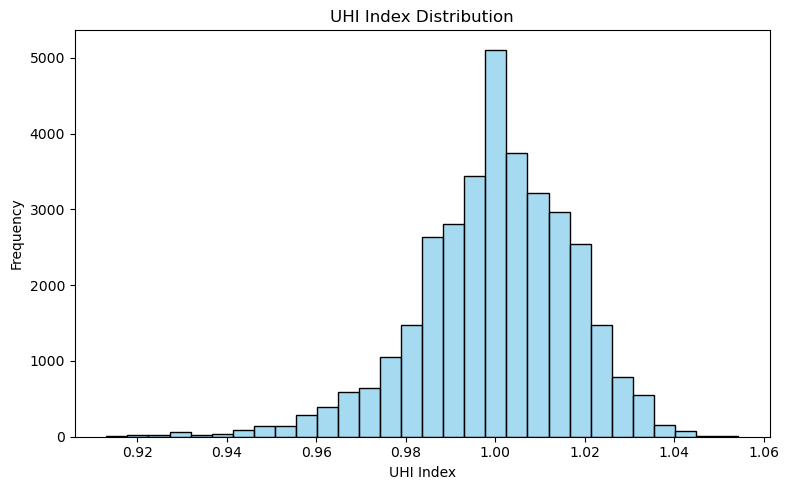

In [191]:
# Plot the histogram
plt.figure(figsize=(8, 5))
sns.histplot(data=model_data, x='UHI Index', bins=30, color='skyblue', kde=False)

# Customize the plot
plt.title('UHI Index Distribution')
plt.xlabel('UHI Index')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### Train and Test Split 

<p align="justify">We will now split the data into 70% training data and 30% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

In [192]:
# Split the data into features (X) and target (y), and then into training and testing sets
X = model_data.drop(columns=['UHI Index'])
y = model_data['UHI Index']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=123)

<Axes: >

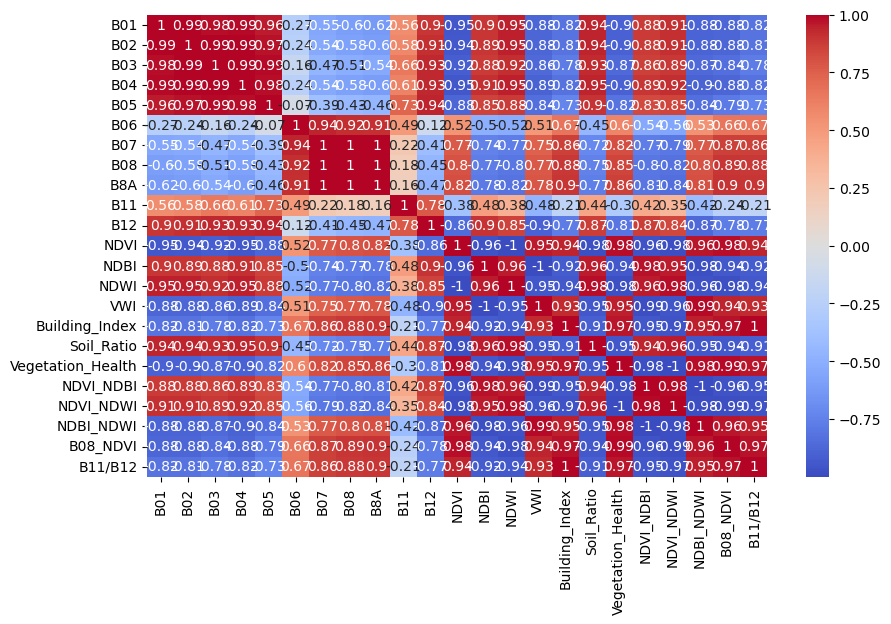

In [193]:
plt.figure(figsize=(10, 6))
corr_matrix = X_train.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

### Feature Scaling 

<p align="justify"> Before initiating the model training we may have to execute different data pre-processing steps. Here we are demonstrating the scaling of B01, B06, NDVI variable by using Standard Scaler.</p>

<p align = "justify">Feature Scaling is a data preprocessing step for numerical features. Many machine learning algorithms like Gradient descent methods, KNN algorithm, linear and logistic regression, etc. require data scaling to produce good results. Scikit learn provides functions that can be used to apply data scaling. Here we are using Standard Scaler. The idea behind Standard Scaler is that it will transform your data such that its distribution will have a mean value 0 and standard deviation of 1.</p>

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 4 </strong></h4>
<p align="justify">There are many data preprocessing methods available, which might help to improve the model performance. Participants should explore various suitable preprocessing methods as well as different machine learning algorithms to build a robust model.</p>

In [194]:
# Scale the training and test data using standardscaler
sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

### Model Training

<p align="justify">Now that we have the data in a format suitable for machine learning, we can begin training a model. In this demonstration notebook, we will use a random forest regression model from the scikit-learn library. This library offers a wide range of other models, each with extensive parameter tuning and customization capabilities.</p>

<p align="justify">Scikit-learn models require the separation of predictor variables and the response variable. We will store the predictor variables (Band B01, B06, NDVI) in array X and the response variable (UHI index) in array Y. It is important not to include the response variable in array X. Additionally, since latitude and longitude do not contribute to the prediction of UHI in this case, we will drop those as well.</p>


## XGboost model

In [ ]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,      # Number of trees (increase for better accuracy)
    learning_rate=0.005,    # Step size shrinkage
    max_depth=20,           # Tree depth
    subsample=0.8,         # Subsampling to prevent overfitting
    colsample_bytree=0.8,  # Features per tree
    reg_lambda=0.001,
    random_state=42
)


# Train the model
xgb_model.fit(X_train_scaled, y_train) 




XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

              Feature  Importance
22            B11/B12    0.062665
14                VWI    0.059196
10                B12    0.058864
12               NDBI    0.058443
15     Building_Index    0.057242
20          NDBI_NDWI    0.053483
16         Soil_Ratio    0.047944
18          NDVI_NDBI    0.045134
19          NDVI_NDWI    0.044718
21           B08_NDVI    0.044342
3                 B04    0.043352
9                 B11    0.042221
0                 B01    0.041818
17  Vegetation_Health    0.040989
13               NDWI    0.040651
8                 B8A    0.039184
4                 B05    0.036160
7                 B08    0.033119
2                 B03    0.033023
6                 B07    0.031777
11               NDVI    0.031432
5                 B06    0.030026
1                 B02    0.024219


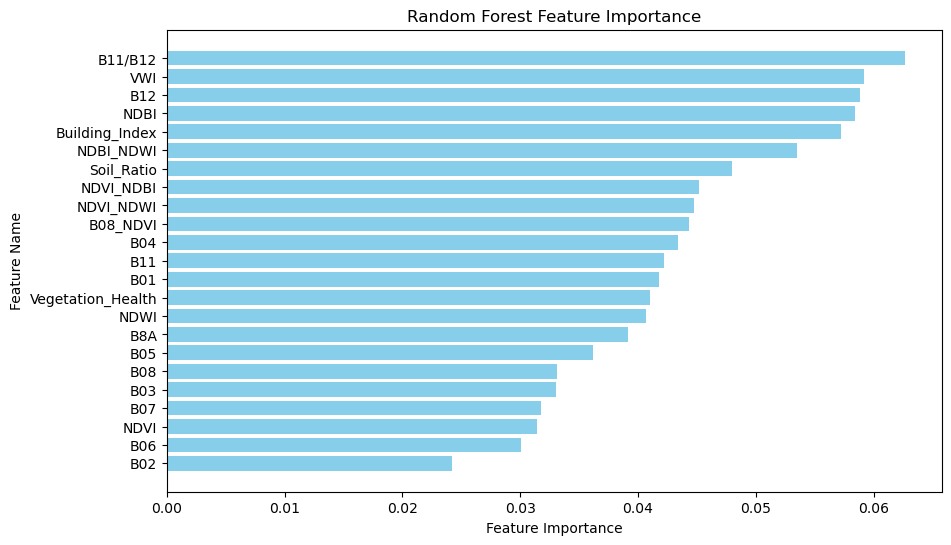

In [ ]:
# Get feature importance scores
feature_importance = xgb_model.feature_importances_

# Convert to DataFrame for better readability
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort by importance (descending)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top features
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()

In [ ]:
# Make predictions on the training data
xgb_training_predictions = xgb_model.predict(X_train_scaled)
# calculate R-squared score for in-sample predictions
Y_train = y_train.tolist()
r2_score(Y_train, xgb_training_predictions)

0.9974021315574646

In [169]:
xgb_y_pred = xgb_model.predict(X_test_scaled)
r2 = r2_score(y_test, xgb_y_pred)
print(f"R-squared (R²): {r2:.4f}")

R-squared (R²): 0.7224


## Submission

Once you are satisfied with your model, you can proceed to make a submission. To do this, you will need to use your model to predict the Urban Heat Island (UHI) index for a set of test coordinates provided in the <b>"Submission_template.csv"</b> file and upload the results to the challenge platform.

In [198]:
#Reading the coordinates for the submission
test_file = pd.read_csv('Submission_Template_IC25.csv')
test_file.head()

,Longitude,Latitude,UHI Index
0,-77.301697,39.109247,NaN
1,-77.300382,39.113362,NaN
2,-77.300285,39.108433,NaN
3,-77.299315,39.107880,NaN
4,-77.299300,39.115225,NaN


In [200]:
import pandas as pd
import rioxarray as rxr
import rasterio
from rasterio.mask import mask
from pyproj import Transformer, CRS
from shapely.geometry import Point, mapping
import numpy as np
import torch
from tqdm import tqdm

def extract_buffered_satellite_data(tiff_path, csv_path, buffer_distance=150, use_gpu=True):
    device = torch.device("cuda" if torch.cuda.is_available() and use_gpu else "cpu")
    print(f"Using device: {device}")

    dataset = rxr.open_rasterio(tiff_path)
    tiff_crs = dataset.rio.crs
    print(f"Original TIFF CRS: {tiff_crs}")
    
    # Ensure the TIFF is in a projected coordinate system (not EPSG:4326)
    if not tiff_crs.is_projected:
        print("Reprojecting TIFF to UTM for correct buffering...")
        reprojected_tiff_path = "reprojected.tif"
        dataset = dataset.rio.reproject(dst_crs=CRS.from_epsg(32618))  # Example UTM Zone 18N
        dataset.rio.to_raster(reprojected_tiff_path)
        tiff_path = reprojected_tiff_path  # Use the reprojected file
        tiff_crs = dataset.rio.crs
        print(f"New TIFF CRS after reprojection: {tiff_crs}")
    
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    transformer = Transformer.from_crs("EPSG:4326", tiff_crs, always_xy=True)
    
    # Convert lat/lon to projected coordinates (meters)
    transformed_coords = np.array(transformer.transform(longitudes, latitudes))
    print("First 5 transformed coordinates (meters):")
    print(transformed_coords[:, :5])

    num_bands = dataset.shape[0]
    band_values = {f'B{band+1:02d}': np.full(len(df), np.nan, dtype=np.float32) for band in range(num_bands)}

    # Check raster bounds
    with rasterio.open(tiff_path) as src:
        raster_bounds = src.bounds
        print(f"Raster bounds: {raster_bounds}")
        
        for idx, (x, y) in tqdm(enumerate(zip(transformed_coords[0], transformed_coords[1])),
                                 total=len(latitudes), desc="Extracting values"):
            if not (raster_bounds.left <= x <= raster_bounds.right and raster_bounds.bottom <= y <= raster_bounds.top):
                print(f"Skipping point {idx} ({x:.2f}, {y:.2f}) - Outside raster bounds")
                continue
            
            point = Point(x, y).buffer(buffer_distance)
            geojson_geom = [mapping(point)]
            
            if idx < 5:  # Print debug info for the first few points
                print(f"Point {idx}: ({x:.2f}, {y:.2f}) -> Buffered Geometry: {geojson_geom}")
            
            try:
                out_image, _ = mask(src, geojson_geom, crop=True)
                
                # Compute the mean for each band
                for band in range(out_image.shape[0]):
                    band_values[f'B{band+1:02d}'][idx] = np.nanmean(out_image[band])
                
                if idx < 5:  # Debug output for the first few iterations
                    print(f"Extracted mean band values for point {idx}:", 
                          [np.nanmean(out_image[band]) for band in range(out_image.shape[0])])
            except Exception as e:
                print(f"Skipping point {idx} ({y:.2f}, {x:.2f}) due to error: {e}")

    band_df = pd.DataFrame(band_values)
    return band_df

# Example usage:
val_data = extract_buffered_satellite_data('S2_output_IC25(complete).tiff', 'Submission_Template_IC25.csv')

Using device: cuda
Original TIFF CRS: EPSG:4326
Reprojecting TIFF to UTM for correct buffering...
New TIFF CRS after reprojection: EPSG:32618
First 5 transformed coordinates (meters):
[[ 300987.85325361  301113.13903164  301107.63692562  301189.96102345
   301211.90737139]
 [4331422.220179   4331876.06852861 4331328.85217935 4331265.31228501
  4332080.51296547]]
Raster bounds: BoundingBox(left=297192.31406539254, bottom=4311830.711916517, right=336053.61640117853, top=4347129.585479343)


Extracting values:   0%|          | 13/3834 [00:00<00:29, 128.47it/s]

Point 0: (300987.85, 4331422.22) -> Buffered Geometry: [{'type': 'Polygon', 'coordinates': (((301137.8532536066, 4331422.220179), (301137.1309626074, 4331407.517607951), (301134.9710456671, 4331392.9566306975), (301131.39430396643, 4331378.677477412), (301126.4351834833, 4331364.8176641455), (301120.14144325885, 4331351.510668476), (301112.57369545195, 4331338.884644047), (301103.804821611, 4331327.061186375), (301093.9192707846, 4331316.154161822), (301083.01224623114, 4331306.268610995), (301071.1887885595, 4331297.499737155), (301058.5627641305, 4331289.931989348), (301045.2557684613, 4331283.6382491235), (301031.3959551948, 4331278.67912864), (301017.116801909, 4331275.102386939), (301002.55582465604, 4331272.942469999), (300987.8532536066, 4331272.220179), (300973.15068255714, 4331272.942469999), (300958.5897053042, 4331275.102386939), (300944.3105520184, 4331278.67912864), (300930.45073875185, 4331283.6382491235), (300917.1437430827, 4331289.931989348), (300904.51771865366, 43312

Extracting values: 100%|██████████| 3834/3834 [00:07<00:00, 534.93it/s]


In [202]:
val_data.columns =  ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
val_data.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12
0,1293.431396,1398.057129,1627.560303,1458.526001,1959.294189,3682.117432,4370.421875,4653.107910,4651.826172,2999.874268,2031.803589
1,1251.699951,1323.031128,1513.805786,1328.603271,1835.105957,3594.357178,4267.973145,4550.843262,4564.517090,2894.228516,1949.638672
2,1263.026978,1358.397095,1602.439697,1398.222412,1869.782715,3871.549805,4813.385742,5054.929199,5039.161133,2914.151855,1918.426147
3,1270.581909,1376.296631,1641.322632,1434.570557,1937.741699,3918.766602,4841.165039,5096.062012,5075.636719,3024.675293,1988.741699
4,1334.650757,1449.622681,1676.183960,1581.175659,2088.848145,3533.355469,4107.949219,4386.135254,4401.963379,3302.485352,2324.008301


In [205]:
# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
val_data['NDVI'] = (val_data['B08'] - val_data['B04']) / (val_data['B08'] + val_data['B04'])
val_data['NDVI'] = val_data['NDVI'].replace([np.inf, -np.inf], np.nan)  # Replace infinities with NaN

val_data['NDBI'] = (val_data['B11'] - val_data['B08']) / (val_data['B11'] + val_data['B08'])
val_data['NDBI'] = val_data['NDBI'].replace([np.inf, -np.inf], np.nan) 

val_data['NDWI'] = (val_data['B03'] - val_data['B08']) / (val_data['B03'] + val_data['B08'])
val_data['NDWI'] = val_data['NDWI'].replace([np.inf, -np.inf], np.nan)

val_data["B11/B12"] = val_data["B11"] / val_data["B12"] 
val_data["VWI"] = val_data["B08"] / val_data["B11"]  
val_data["Building_Index"] = val_data["B11"] / val_data["B12"] 
val_data["Soil_Ratio"] = val_data["B06"] / val_data["B07"] 
val_data["Vegetation_Health"] = val_data["B08"] / val_data["B02"]
val_data["NDVI_NDBI"] = val_data["NDVI"] * val_data["NDBI"]
val_data["NDVI_NDWI"] = val_data["NDVI"] * val_data["NDWI"]
val_data["NDBI_NDWI"] = val_data["NDBI"] * val_data["NDWI"]
val_data["B08_NDVI"] = val_data["B08"] * val_data["NDVI"]

In [206]:
val_data.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,...,NDWI,B11/B12,VWI,Building_Index,Soil_Ratio,Vegetation_Health,NDVI_NDBI,NDVI_NDWI,NDBI_NDWI,B08_NDVI
0,1293.431396,1398.057129,1627.560303,1458.526001,1959.294189,3682.117432,4370.421875,4653.107910,4651.826172,2999.874268,...,-0.481724,1.476459,1.551101,1.476459,0.842508,3.328267,-0.112917,-0.251799,0.104064,2432.203125
1,1251.699951,1323.031128,1513.805786,1328.603271,1835.105957,3594.357178,4267.973145,4550.843262,4564.517090,2894.228516,...,-0.500777,1.484495,1.572386,1.484495,0.842170,3.439710,-0.121948,-0.274452,0.111429,2494.096924
2,1263.026978,1358.397095,1602.439697,1398.222412,1869.782715,3871.549805,4813.385742,5054.929199,5039.161133,2914.151855,...,-0.518597,1.519033,1.734614,1.519033,0.804330,3.721246,-0.152223,-0.293865,0.139313,2864.398193
3,1270.581909,1376.296631,1641.322632,1434.570557,1937.741699,3918.766602,4841.165039,5096.062012,5075.636719,3024.675293,...,-0.512772,1.520899,1.684829,1.520899,0.809468,3.702735,-0.143011,-0.287493,0.130795,2857.179199
4,1334.650757,1449.622681,1676.183960,1581.175659,2088.848145,3533.355469,4107.949219,4386.135254,4401.963379,3302.485352,...,-0.447016,1.421030,1.328132,1.421030,0.860126,3.025708,-0.066250,-0.210122,0.063003,2061.721191


In [207]:
# Extracting specific columns (B02, B03, and NDVI) from the validation dataset
submission_val_data=val_data.loc[:,['B01', 'B02','B03','B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12', 'NDVI', 'NDBI', 'NDWI', 
'VWI', 'Building_Index', 'Soil_Ratio', 'Vegetation_Health', "NDVI_NDBI", "NDVI_NDWI", "NDBI_NDWI", "B08_NDVI", "B11/B12"]]
submission_val_data.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,...,NDWI,VWI,Building_Index,Soil_Ratio,Vegetation_Health,NDVI_NDBI,NDVI_NDWI,NDBI_NDWI,B08_NDVI,B11/B12
0,1293.431396,1398.057129,1627.560303,1458.526001,1959.294189,3682.117432,4370.421875,4653.107910,4651.826172,2999.874268,...,-0.481724,1.551101,1.476459,0.842508,3.328267,-0.112917,-0.251799,0.104064,2432.203125,1.476459
1,1251.699951,1323.031128,1513.805786,1328.603271,1835.105957,3594.357178,4267.973145,4550.843262,4564.517090,2894.228516,...,-0.500777,1.572386,1.484495,0.842170,3.439710,-0.121948,-0.274452,0.111429,2494.096924,1.484495
2,1263.026978,1358.397095,1602.439697,1398.222412,1869.782715,3871.549805,4813.385742,5054.929199,5039.161133,2914.151855,...,-0.518597,1.734614,1.519033,0.804330,3.721246,-0.152223,-0.293865,0.139313,2864.398193,1.519033
3,1270.581909,1376.296631,1641.322632,1434.570557,1937.741699,3918.766602,4841.165039,5096.062012,5075.636719,3024.675293,...,-0.512772,1.684829,1.520899,0.809468,3.702735,-0.143011,-0.287493,0.130795,2857.179199,1.520899
4,1334.650757,1449.622681,1676.183960,1581.175659,2088.848145,3533.355469,4107.949219,4386.135254,4401.963379,3302.485352,...,-0.447016,1.328132,1.421030,0.860126,3.025708,-0.066250,-0.210122,0.063003,2061.721191,1.421030


In [208]:
# Feature Scaling 
submission_val_data = submission_val_data.values
transformed_submission_data = sc.transform(submission_val_data)

In [209]:
#Making predictions
final_predictions = xgb_model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [210]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Longitude':test_file['Longitude'].values, 'Latitude':test_file['Latitude'].values, 'UHI Index':final_prediction_series.values})

In [211]:
#Displaying the sample submission dataframe
submission_df.head()

,Longitude,Latitude,UHI Index
0,-77.301697,39.109247,0.991816
1,-77.300382,39.113362,0.980327
2,-77.300285,39.108433,0.992202
3,-77.299315,39.107880,0.988489
4,-77.299300,39.115225,0.978676


In [212]:
#Dumping the predictions into a csv file.
submission_df.to_csv("Predicted_Data_IC25.csv",index = False)

### Upload submission file on platform

Upload the submission.csv on the <a href ="https://challenge.ey.com">platform</a> to get score generated on scoreboard.

## Conclusion

<div align ="justify">Now that you have learned a basic approach to model training, it’s time to try your own approach! Feel free to modify any of the functions presented in this notebook. We look forward to seeing your version of the model and the results. Best of luck with the challenge!</div>